In [ ]:
import matplotlib, sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")

import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt

np.seterr(all="ignore")
from threeML import *
from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import traceback
silence_warnings()
import warnings
warnings.simplefilter("ignore")
silence_warnings()
from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
from threeML.utils.progress_bar import trange

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
from astropy.coordinates import Angle

import healpy as hp

from tqdm import tqdm

# from mylib import *
import mylib as my
from importlib import reload

In [ ]:
# you can do some change about the lib and reload it any time.
reload(my)

In [ ]:
#####   Data Initialize

# or KM2A
maptree = "../../data/KM2A1234full_skymap_rcy.root"
response = "../../data/KM2A1234full_mcpsf_DRfinal.root"

region_name="Crab"
if not os.path.exists(f'../res/{region_name}/'):
    os.system(f'mkdir ../res/{region_name}/')
ra, dec =  83.62, 22.01
ra1,dec1=ra, dec

data_radius = 6.0
model_radius = 8.0
roi=HealpixConeROI(ra=ra1,dec=dec1,data_radius=data_radius,model_radius=model_radius)  
KM2A = HAL("KM2A", maptree, response, roi, flat_sky_pixels_size=0.1)

#####   Data Situation
%matplotlib inline
KM2A.set_active_measurements(0, 13)
KM2A.display()

fig = KM2A.display_stacked_image(smoothing_kernel_sigma=0.25)
fig.show()
fig.savefig(f"../res/{region_name}/counts_all.png",dpi=300)

In [1]:
Modelname="1pt+1gaus+DGE_KM2A"  # Name your model now to facilitate the creation of record folders by the program.
if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
    os.system(f'mkdir ../res/{region_name}/{Modelname}/')

#Without extended parameter settings, it's a point source. When you set the corresponding extension, it becomes the respective source.
# crab = my.setsorce("crab",ra1,dec1, fitrange=1,
#                 indexb=(-10,-1), kb=(1e-14, 1e-8),
#                 )

crab = my.setsorce("crab",ra1,dec1, fitrange=0.5, alpha= -2.6, beta=0.1, piv=50,
                spec=Log_parabola(), kb=(1e-16, 1e-10)
                )

ext1 = my.setsorce("ext1",85.5, 23.5, sigma=0.5, fitrange=0.5, sb=(0,3), piv=50, 
                indexb=(-4, -1), kb=(1e-17, 1e-10)
                )

Diffuse = my.set_diffusebkg(
                ra1, dec1,
                piv=50,
                Kb=(1e-17, 1e-10),
                # K = 3.3e-13, index = -2.3,
                Kf=False, indexf=False
                )

lm = Model(crab, ext1, Diffuse) #

with open(f'../res/{region_name}/{Modelname}/Model_init.txt', 'w') as f:
    for key, value in lm.parameters.items():
        f.write(f'{key}: {value}\n')

lm.display(complete=True)

NameError: name 'os' is not defined

In [ ]:
# Attempt the fitting; it will take approximately two minutes.
result = my.fit(region_name, Modelname, KM2A, lm, 0, 12, mini="minuit")
sources = my.get_sources(lm,result)
result[1][0]
# result[0].get_contours(J0248.Gaussian_on_sphere.lon0,39.88,44.88,30)

In [ ]:
fig = KM2A.display_spectrum()

In [ ]:
# Don't try this!!!! as it requires a significant amount of time!!!"
gof_obj = GoodnessOfFit(result[0])
gof, data_frame, like_data_frame = gof_obj.by_mc(n_iterations=200)

In [ ]:
# Compute Ts,  it will take approximately five minutes.
TSlist = ["crab", "ext1", "Diffuse"]  # A list put the sources that you want to compute TS
TS, TSresults = my.getTSall(TSlist, region_name, Modelname, result, KM2A)
TSresults

In [ ]:
%matplotlib inline
sources = my.get_sources(lm,result)
sources.pop("Diffuse")
sources["HAWC J0543+233"]=sources.pop("ext1")
sources["Crab"]=sources.pop("crab")
# sources={}
map2, skymapHeader = hp.read_map("../../data/fullsky_WCDA_llh-2.6.fits.gz",h=True)
map2 = hp.ma(map2)
fig = my.drawmap(region_name, Modelname, sources, map2, ra1, dec1, rad=2*data_radius, contours=[1000],save=True, cat={})
plt.legend()

In [14]:
Flux_WCDA, jls1 = my.getdatapoint(KM2A, lm, maptree, response, roi, "crab", piv=50) #, ifpowerlawM=1
Flux_WCDA2, jls2 = my.getdatapoint(KM2A, lm, maptree, response, roi, "ext1", ifpowerlawM=1, piv=50)
Flux_WCDA3, jls3 = my.getdatapoint(KM2A, lm, maptree, response, roi, "Diffuse", ifpowerlawM=1, piv=50)

00:46:25 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=76298;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=9483;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=135094;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=904388;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=788466;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=21116;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=397901;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=582681;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=543409;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=485905;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=155094;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=19927;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(5.18 -0.24 +0.26) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1502.704779
total,1502.704779


Values of statistical measures:

,statistical measures
AIC,3007.409567
BIC,3018.496432


00:46:27 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=847858;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=301851;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=880548;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=431337;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=280328;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=613760;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=613820;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=286520;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=583614;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=56594;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=71633;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=432853;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=400235;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=21430;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=730858;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=194832;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=501204;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=835797;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=618132;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=728792;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:46:32 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=751124;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=762811;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=704264;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=460204;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=906633;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=910759;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=629350;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=222476;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=879347;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=449108;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=745590;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=980009;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(7.04 +/- 0.14) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1501.845276
total,1501.845276


Values of statistical measures:

,statistical measures
AIC,3005.690560
BIC,3016.777424


00:46:33 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=710445;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=953368;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=668347;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=284765;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=489284;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=824168;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=365162;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=760677;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=517623;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=851206;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=76939;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=665077;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

00:46:34 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=3804;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=832576;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=417126;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=171054;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=549428;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=575787;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=781627;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=812190;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:46:38 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=708054;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=857426;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=409141;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=424628;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=624277;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=361796;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=206763;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=279792;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=851872;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=97847;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=347267;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=931186;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(7.17 +/- 0.11) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1586.095255
total,1586.095255


Values of statistical measures:

,statistical measures
AIC,3174.190519
BIC,3185.277383


00:46:39 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=743189;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=551949;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=237366;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=464196;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=337041;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=904020;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=758012;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=574788;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=829414;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=928674;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=760512;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=787147;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=384860;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=569226;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=957695;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=309478;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=445924;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=172401;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=670049;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=503824;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:46:44 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=334383;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=443499;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=588614;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=760849;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=313014;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=953814;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=51186;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=671774;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=390764;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=254693;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=94858;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=704923;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(6.84 -0.10 +0.11) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1552.469894
total,1552.469894


Values of statistical measures:

,statistical measures
AIC,3106.939797
BIC,3118.026661


00:46:45 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=315533;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=279985;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=230616;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=799251;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=851795;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=490032;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=592511;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=868007;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=624421;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=999249;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=861224;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=145303;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

00:46:46 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=221107;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=322263;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=792106;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=693310;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=854034;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=821952;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=399438;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=847711;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:46:50 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=418713;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=789749;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=836968;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=672059;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=452943;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=823340;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=852112;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=952923;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=790658;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=355265;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=304982;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=125627;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(6.69 -0.12 +0.13) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1562.626106
total,1562.626106


Values of statistical measures:

,statistical measures
AIC,3127.252221
BIC,3138.339086


         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=842423;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=577232;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=403240;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=754798;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=31033;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=906113;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=24584;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=531677;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=876703;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=48550;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=871386;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=713905;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

00:46:51 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=875660;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=364487;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=169516;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=250909;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=597856;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=821328;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=147051;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=523139;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:46:54 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=310042;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=273596;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=976426;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=378062;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=751622;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=962978;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=184695;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=762976;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=958721;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=348180;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=457563;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=864489;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(6.40 -0.17 +0.18) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1439.351103
total,1439.351103


Values of statistical measures:

,statistical measures
AIC,2880.702215
BIC,2891.789080


         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=660690;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=38437;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=968133;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=325551;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=332795;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=887798;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=641509;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=196193;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=161702;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=416894;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=794090;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=418933;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=570516;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=446412;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=285621;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=845955;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=731603;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=101736;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=799633;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=222477;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:46:58 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=365015;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=850728;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=571474;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=717283;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=24404;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=198981;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=890931;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=629871;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=893770;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=390746;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=925927;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=660452;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(6.61 -0.23 +0.24) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1397.766497
total,1397.766497


Values of statistical measures:

,statistical measures
AIC,2797.533002
BIC,2808.619866


00:46:59 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=780161;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=775851;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=820121;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=239150;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=960854;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=772370;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=116789;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=331928;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=129597;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=350766;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=605607;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=846812;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=417916;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=760904;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=778413;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=263466;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=653579;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=634546;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=312843;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=560206;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:47:03 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=412;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=191143;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=634830;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=115696;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=571669;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=549379;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=579132;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=128382;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=269706;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=533140;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=384745;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=456685;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(7.1 +/- 0.4) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1108.941005
total,1108.941005


Values of statistical measures:

,statistical measures
AIC,2219.882019
BIC,2230.968883


00:47:04 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=974969;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=871695;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=792815;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=376692;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=602022;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=216733;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=952719;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=226389;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=116207;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=990734;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=801784;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=301697;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=277340;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=716751;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=483943;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=553249;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=884316;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=969078;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=179429;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=588014;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:47:08 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=609752;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=779652;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=705526;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=185260;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=105747;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=629752;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=254476;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=401865;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=690676;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=63418;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=474586;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=40013;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(8.2 +/- 0.7) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,699.542752
total,699.542752


Values of statistical measures:

,statistical measures
AIC,1401.085512
BIC,1412.172376


00:47:09 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=522355;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=114918;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=960546;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=213135;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=384920;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=953959;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=517300;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=399714;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=318610;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=746390;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=12111;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=788690;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=313011;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=928624;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=813571;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=734028;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=312853;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=245474;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=461389;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=810224;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:47:13 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=443727;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=32207;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=801411;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=731507;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=629106;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=361188;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=792368;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=826466;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=441664;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=585132;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=13133;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=993909;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(6.1 -1.0 +1.2) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,322.64026
total,322.64026


Values of statistical measures:

,statistical measures
AIC,647.280528
BIC,658.367393


         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=454438;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=322809;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=209433;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=531680;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=585160;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=663375;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=253990;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=880917;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=451724;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=948920;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=116324;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=377504;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=222204;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=720589;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=160847;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=818426;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=211482;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=470938;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=546706;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=603808;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:47:17 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=76844;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=747059;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=562626;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=166898;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=67663;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=435138;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=8680;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=995546;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=312457;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=851016;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=968213;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=117145;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(1.14 -0.24 +0.31) x 10^-24,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,196.377799
total,196.377799


Values of statistical measures:

,statistical measures
AIC,394.755607
BIC,405.842472


         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=771594;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=851058;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=269769;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=305864;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=590341;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=754103;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=152885;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=208730;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=594419;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=775131;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=965270;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=438851;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=623880;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=759534;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=426728;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=241887;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=948429;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=972218;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=978457;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=302077;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:47:22 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=643170;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=998122;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=186094;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=449999;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=146995;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=1587;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=312676;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=23518;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=192335;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=918065;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=221312;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=415308;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(10 -4 +6) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,98.568503
total,98.568503


Values of statistical measures:

,statistical measures
AIC,199.137015
BIC,210.223880


         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=507526;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=719365;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=521079;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=955300;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=279039;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=908002;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=636030;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=302390;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=340521;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=945731;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=406629;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=670384;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=360494;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=505873;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=913245;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=405034;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=780596;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=839244;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=385834;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=301244;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:47:27 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=60608;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=56094;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=810942;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=704939;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=760433;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=171015;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=60506;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=846026;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=638628;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=501446;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=439371;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=409182;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(2.8 -1.3 +2.3) x 10^-24,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,53.259401
total,53.259401


Values of statistical measures:

,statistical measures
AIC,108.518811
BIC,119.605676


00:47:28 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=24378;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=580172;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=518139;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=754333;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=713426;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=778140;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=590230;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=45543;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=739782;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=786872;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=978477;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=461170;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=26938;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=315735;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=425531;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=353737;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=341971;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=144978;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=658697;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=349548;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:47:34 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=499622;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=506529;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=750540;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=819953;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=410100;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=936517;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=780770;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=249127;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=282514;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=883492;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=698867;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=168095;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(3.0 +/- 3.5) x 10^-26,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1498.040516
total,1498.040516


Values of statistical measures:

,statistical measures
AIC,2998.081040
BIC,3009.167905


00:47:37 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=134884;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=432861;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=533172;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=7782;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=424515;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=985741;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=812102;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=553940;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

00:47:38 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=714607;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=683451;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=505024;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=197111;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=931504;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=450406;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=711184;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=807763;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:47:43 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=992912;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=515429;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=748048;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=65922;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=795010;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=524237;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=617027;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=231442;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=419145;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=842307;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=962850;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=576197;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(1.07 +/- 0.25) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1482.241833
total,1482.241833


Values of statistical measures:

,statistical measures
AIC,2966.483675
BIC,2977.570539


00:47:45 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=362796;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=562102;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=484168;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=38031;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=696299;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=106512;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=626263;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=525471;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

00:47:46 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=640218;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=979319;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=909171;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=477641;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=673983;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=228741;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=294626;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=985621;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:47:49 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=476062;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=644246;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=732316;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=790789;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=11324;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=593141;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=663268;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=117764;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=239161;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=447457;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=278587;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=726326;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(2.34 +/- 0.24) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1593.203277
total,1593.203277


Values of statistical measures:

,statistical measures
AIC,3188.406563
BIC,3199.493427


00:47:51 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=671197;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=773328;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=440549;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=827519;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=859945;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=941101;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=259685;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=359758;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=412303;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=916202;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=769996;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=153339;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=386359;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=49330;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=542555;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=462279;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:47:55 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=589123;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=282824;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=68951;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=405368;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=600644;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=58940;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=916619;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=589175;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=737248;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=283564;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=209227;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=122312;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(3.95 +/- 0.25) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1541.329731
total,1541.329731


Values of statistical measures:

,statistical measures
AIC,3084.659471
BIC,3095.746335


00:47:57 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=587686;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=147009;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=444062;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=992408;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=659334;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=688823;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=329333;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=324192;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=351967;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=616697;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=636904;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=599020;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=535253;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=439662;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=524141;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=361676;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:48:00 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=935758;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=146006;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=662383;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=377807;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=996611;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=305650;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=469869;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=62685;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=232473;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=268383;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=515824;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=360315;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(4.54 +/- 0.22) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1527.075671
total,1527.075671


Values of statistical measures:

,statistical measures
AIC,3056.151351
BIC,3067.238216


00:48:02 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=701151;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=806392;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=925813;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=364549;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=674926;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=259413;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=157418;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=236354;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=371553;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=549567;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=475534;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=963945;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=523902;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=652981;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=413539;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=34063;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:48:05 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=397884;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=914910;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=528635;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=847064;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=596809;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=87130;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=140029;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=935279;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=278487;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=485001;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=862992;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=340427;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(4.19 +/- 0.23) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1419.278197
total,1419.278197


Values of statistical measures:

,statistical measures
AIC,2840.556401
BIC,2851.643266


00:48:07 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=378354;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=74352;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=978220;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=431863;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=459693;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=577314;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=333408;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=122563;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=584950;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=175005;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=468254;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=379442;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=859528;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=575782;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=30436;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=61292;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:48:10 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=406568;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=341239;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=609896;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=78914;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=228606;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=110363;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=98093;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=400808;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=595543;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=287068;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=656217;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=299746;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(3.04 +/- 0.25) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1397.180133
total,1397.180133


Values of statistical measures:

,statistical measures
AIC,2796.360275
BIC,2807.447140


00:48:12 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=270350;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=388951;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=478216;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=88805;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=855813;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=620860;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=436283;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=735116;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=264031;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=219222;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=616065;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=60202;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=161581;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=299867;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=291910;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=21994;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:48:16 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=212318;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=764653;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=606438;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=784595;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=791071;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=964896;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=824037;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=232262;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=179958;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=934671;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=270772;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=902256;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(1.28 +/- 0.25) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1095.955761
total,1095.955761


Values of statistical measures:

,statistical measures
AIC,2193.911531
BIC,2204.998395


00:48:19 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=309810;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=624478;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=502001;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=191030;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=373503;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=395210;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=328633;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=820059;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=755793;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=582766;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=635796;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=238749;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=523494;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=627096;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=827838;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=681987;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:48:23 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=499278;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=888972;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=867000;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=85314;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=608685;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=604540;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=939262;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=154637;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=336236;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=913472;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=354239;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=950564;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(5.4 +/- 2.8) x 10^-26,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,683.557383
total,683.557383


Values of statistical measures:

,statistical measures
AIC,1369.114774
BIC,1380.201639


00:48:24 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=217257;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=878725;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=719395;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=304559;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=582363;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=114444;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=49093;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=241729;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=794449;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=366404;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=210240;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=410822;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=784192;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=605556;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=310111;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=17869;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:48:28 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=197269;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=208789;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=775331;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=597569;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=65997;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=430391;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=468781;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=924835;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=479900;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=706613;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=387062;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=988670;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(-3.8 +/- 3.2) x 10^-26,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,304.919524
total,304.919524


Values of statistical measures:

,statistical measures
AIC,611.839057
BIC,622.925922


00:48:30 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=684175;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=945524;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=974995;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=41171;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=237;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=970599;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=600995;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=925842;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=682602;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=925893;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=668973;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=930152;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=23767;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=647438;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=998656;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=537087;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:48:34 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=696814;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=790876;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=74270;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=88590;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=794402;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=503260;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=556787;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=374432;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=817802;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=232588;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=652477;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=195356;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(-5.5 +/- 3.0) x 10^-26,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,186.618692
total,186.618692


Values of statistical measures:

,statistical measures
AIC,375.237392
BIC,386.324257


00:48:37 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=716783;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=668188;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=202136;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=898372;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=517926;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=882399;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=473877;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=582475;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=220714;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=827874;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=972716;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=754961;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=175062;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=778572;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=342218;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=419004;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:48:41 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=867994;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=125648;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=3194;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=961114;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=633493;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=608656;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=241725;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=980938;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=397393;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=736559;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=676103;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=870692;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(9 +/- 8) x 10^-26,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,97.372417
total,97.372417


Values of statistical measures:

,statistical measures
AIC,196.744842
BIC,207.831707


00:48:43 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=941946;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=547481;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=735934;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=270808;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=665106;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=753547;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=788715;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=894184;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=382667;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=394932;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=500311;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=820854;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=765639;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=404559;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=898451;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=85794;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:48:46 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=174700;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=410905;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=357525;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=806008;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=152044;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=294341;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=326093;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=97927;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=182235;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=886465;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=776301;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=368089;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
ext1.spectrum.main.PowerlawM.K,(-0.4 +/- 1.7) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,53.892484
total,53.892484


Values of statistical measures:

,statistical measures
AIC,109.784976
BIC,120.871841


00:48:50 INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=780508;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=30159;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=169428;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=286146;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=637418;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=294075;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=186387;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=250422;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=772268;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=562104;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=509807;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=296986;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=761872;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=617801;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=334063;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=61587;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:48:54 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=618091;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=997464;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=732048;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=830405;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=973871;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=463405;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=878082;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=507949;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=760506;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=683069;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=544268;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=62938;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-4.7 +/- 1.2) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1510.744341
total,1510.744341


Values of statistical measures:

,statistical measures
AIC,3023.488690
BIC,3034.575555


00:48:56 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=136002;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=147103;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=696780;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=314988;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=978894;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=838330;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=780182;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=277700;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=585131;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=322167;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=515972;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=283842;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=162188;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=165568;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=467857;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=816957;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:00 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=823460;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=434148;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=843454;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=245898;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=322554;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=626191;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=460051;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=454190;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=436434;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=654405;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=878349;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=491826;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-1.6 +/- 0.9) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1500.20436
total,1500.20436


Values of statistical measures:

,statistical measures
AIC,3002.408728
BIC,3013.495593


00:49:02 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=157343;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=709005;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=86208;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=394709;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=433579;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=85942;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=505652;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=83326;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

00:49:03 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=450941;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=643331;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=855801;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=423628;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=130114;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=507685;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=61893;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=849580;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:06 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=156910;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=186029;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=324726;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=132999;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=462338;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=916280;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=378588;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=656025;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=642243;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=130992;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=439471;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=642105;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(1.5 +/- 1.0) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1594.440546
total,1594.440546


Values of statistical measures:

,statistical measures
AIC,3190.881100
BIC,3201.967965


00:49:08 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=359579;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=216981;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=64225;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=474889;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=392566;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=692456;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=406323;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=590097;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=152255;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=638219;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=673542;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=876665;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=227565;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=932033;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=30429;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=460215;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:11 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=782461;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=767252;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=708881;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=240810;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=533786;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=240086;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=773436;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=291167;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=502122;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=224272;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=208549;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=840538;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(3.9 +/- 1.0) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1549.681437
total,1549.681437


Values of statistical measures:

,statistical measures
AIC,3101.362883
BIC,3112.449747


00:49:13 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=22212;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=103220;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=810639;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=346169;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=792836;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=171211;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=998513;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=935979;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=72325;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=922475;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=987885;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=232935;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=37826;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=852815;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=976374;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=720326;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:17 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=3428;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=884959;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=335458;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=367203;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=505690;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=539674;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=374845;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=574201;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=249641;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=396875;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=154983;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=70952;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(4.3 +/- 0.9) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1556.113201
total,1556.113201


Values of statistical measures:

,statistical measures
AIC,3114.226410
BIC,3125.313275


00:49:18 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=485149;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=127978;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=241319;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=145764;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=233300;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=750374;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=655390;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=474177;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=33860;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=59027;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=31274;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=103904;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=660884;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=370177;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=687730;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=314269;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:21 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=449172;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=772906;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=110592;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=468847;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=233973;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=421324;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=42879;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=512497;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:22 INFO      set the minimizer to minuit                                             ]8;id=980949;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=222938;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=205988;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=423757;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(3.5 +/- 0.9) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1437.189024
total,1437.189024


Values of statistical measures:

,statistical measures
AIC,2876.378057
BIC,2887.464921


00:49:23 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=437288;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=808478;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=959007;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=759855;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=74716;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=367416;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=171856;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=561794;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=165941;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=486357;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=762123;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=535624;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=663259;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=332448;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=412401;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=120204;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:26 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=520565;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=750986;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=455017;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=953133;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=595834;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=14044;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=747497;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=293669;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=659690;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=664399;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=580328;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=302479;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(3.6 +/- 1.0) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1394.587841
total,1394.587841


Values of statistical measures:

,statistical measures
AIC,2791.175689
BIC,2802.262554


00:49:27 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=526281;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=86377;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=146262;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=474819;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=714651;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=968429;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=738182;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=272481;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=709052;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=33041;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=485554;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=882746;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=110420;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=715380;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=632917;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=133545;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:30 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=331266;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=414364;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=305137;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=661655;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=134002;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=977672;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=446824;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=320853;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=634908;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=738080;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=123037;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=940959;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-6 +/- 10) x 10^-26,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,1107.879905
total,1107.879905


Values of statistical measures:

,statistical measures
AIC,2217.759818
BIC,2228.846683


00:49:32 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=795645;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=346410;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=294924;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=917191;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=493272;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=104370;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=228167;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=772171;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=115860;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=412289;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=632922;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=47823;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=325408;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=895861;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=50627;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=111852;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:35 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=405964;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=30973;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=298271;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=715028;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=333522;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=515236;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=457263;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=589982;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=141874;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=465968;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=433781;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=69452;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-1.1 +/- 1.2) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,700.214486
total,700.214486


Values of statistical measures:

,statistical measures
AIC,1402.428980
BIC,1413.515845


00:49:37 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=8306;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=699533;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=364258;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=643012;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=481027;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=638975;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=66078;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=142822;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=580818;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=595661;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=3383;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=590646;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=518040;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=154360;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=860106;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=412667;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:39 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=68205;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=303444;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=900589;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=805545;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=71219;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=94334;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=792828;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=663129;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=618801;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=890150;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=604160;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=212433;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-2.3 +/- 1.5) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,320.735757
total,320.735757


Values of statistical measures:

,statistical measures
AIC,643.471522
BIC,654.558387


00:49:41 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=30584;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=153909;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=568935;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=493910;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=499521;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=533262;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=378271;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=334985;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

00:49:42 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=682221;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=668770;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=668937;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=493009;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=366728;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=147980;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=265964;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=296831;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:45 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=146998;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=847225;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=748234;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=738913;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=643466;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=417962;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=907521;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=537039;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=239159;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=766085;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=776200;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=318976;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-2.1 +/- 1.9) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,197.274592
total,197.274592


Values of statistical measures:

,statistical measures
AIC,396.549192
BIC,407.636057


00:49:47 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=679861;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=794753;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=674277;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=183866;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=646292;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=190247;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=902;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=923455;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=851930;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=520680;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=546225;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=911529;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=219287;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=616491;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=240163;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=525397;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:50 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=891244;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=760774;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=661467;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=357483;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=550721;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=39395;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=517803;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=889663;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=843980;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=585740;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=454328;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=946978;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-2.8 +/- 2.6) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,98.023331
total,98.023331


Values of statistical measures:

,statistical measures
AIC,198.046671
BIC,209.133536


00:49:53 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=95104;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=868105;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=189293;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=898505;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=304889;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=65433;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=653074;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=938450;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=887999;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=574865;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=84784;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=900802;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=812224;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=50040;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=987938;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=197460;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

00:49:56 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=250986;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=574087;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=462044;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=713363;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=255717;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=750807;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=812470;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=556353;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=448908;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=797867;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=85177;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=307313;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(4 +/- 7) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,54.926257
total,54.926257


Values of statistical measures:

,statistical measures
AIC,111.852522
BIC,122.939386


00:49:58 INFO      Considering 15 dec bins for extended source ext1                 ]8;id=704535;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=225579;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=799464;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=436914;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=83586;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=586257;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=139848;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=190269;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      Considering 15 dec bins for extended source ext1                 ]8;id=943222;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=389281;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 23.129                       ]8;id=489183;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=600456;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 12 dec bins for extended source Diffuse              ]8;id=439673;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=190684;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 29.209                       ]8;id=402069;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=97985;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]

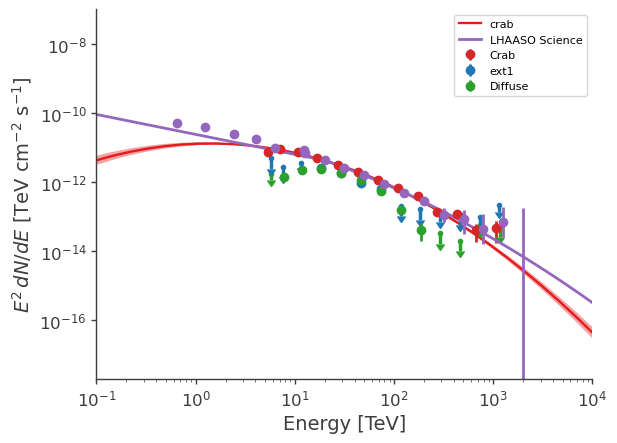

In [17]:
%matplotlib inline
x_Max=10000.
x_Min=.1
y_Min=0.2e-17
y_Max=1e-7
fig,ax = plt.subplots()
plot_spectra(
    result[0].results,
    sources_to_use=["crab"],
    include_extended=True,
    ene_min=x_Min,
    ene_max=x_Max,
    num_ene=30,
    energy_unit="TeV",
    flux_unit="TeV/(s cm2)",
    subplot=ax
    )

my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA,"Crab","tab:red")
my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA3,"ext1","tab:blue")
my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA2,"Diffuse","tab:green")

e_J0248=np.linspace(x_Min,x_Max,500)
crab_data = np.array([[0.645589, 4.99911e-11, 5.2533e-12],
[1.23979, 3.89817e-11, 2.24529e-12],
[2.42276, 2.40127e-11, 1.76418e-12],
[4.06902, 1.73829e-11, 1.68635e-12],
[6.35322, 9.85614e-12, 1.47362e-12],
[12.3595, 8.32206e-12, 8.84423e-13]])

crab_data_km2a = np.array([
[12.59, 6.78e-12,  2.90e-13,  2.90e-13],
[19.95, 4.21e-12,  1.76e-13,  1.76e-13],
[31.62, 2.55e-12,  1.16e-13,  1.16e-13],
[50.12, 1.59e-12,  1.00e-13,  1.00e-13],
[79.43, 8.94e-13,  7.54e-14,  7.54e-14],
[125.89, 4.67e-13,  6.46e-14,  6.46e-14],
[199.53, 2.84e-13,  6.04e-14,  6.04e-14],
[316.23, 1.10e-13,  4.12e-14,  6.22e-14],
[501.19, 8.55e-14,  5.42e-14,  6.67e-14],
[794.33, 4.33e-14,  2.74e-14,  7.65e-14],
[1258.93,  6.83e-14 , 4.30e-14 , 1.20e-13],
[1995.26,  -2.12e-16,  0.00e+00,  1.73e-13]])
flux_J0248_sci=e_J0248**2*8.2e-14*pow(e_J0248/10,-2.9-0.19*np.log10(e_J0248/10))
plt.errorbar(crab_data[:,0], crab_data[:,1], crab_data[:,2],fmt="o", c = "tab:purple") #,label='Crab Science'
plt.errorbar(crab_data_km2a[:,0], crab_data_km2a[:,1], [crab_data_km2a[:,2], crab_data_km2a[:,3]],fmt="o", c = "tab:purple") 
plt.plot(e_J0248,flux_J0248_sci,label='LHAASO Science', c = "tab:purple")

# LHAASO_sensitivity = np.genfromtxt("./LHAASO_sensitivity.csv",delimiter=',')
# plt.plot(LHAASO_sensitivity[:,0],LHAASO_sensitivity[:,1]*1e-11,label="LHAASO 1yr", c="black")

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
plt.legend()
plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.png', dpi=300)
plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.pdf')

In [ ]:
f1 = Flux_WCDA[0][3]*1e9*Flux_WCDA[0][0]**2
e1 = Flux_WCDA[0][0]
f2=Flux_WCDA[0][0]**2*8.2e-14*pow(Flux_WCDA[0][0]/10,-2.9-0.19*np.log10(Flux_WCDA[0][0]/10))
print(e1, f1, f2, (f2-f1)/f2)

In [32]:
# If you want to get residual llh map, you need a new rootfile.
my.write_resmap(region_name, Modelname, KM2A, roi, maptree, 
ra1, dec1, "crab_res",
[0],[0,0], #point source and ext source, if you have 3pt and 2 ext, and you only want sig about pt1, then use [1,0,0],[0, 0], or you only want 2nd ext: [0,0,0],[0,1]
data_radius,
binc="all",
detector="KM2A"
)
# ! The file you got need use Add_UserInfo.cc in ./tools/llh_skymap to add UserInfo

processing at nHit0 0


100%|██████████| 34469/34469 [00:01<00:00, 21145.90it/s]


processing at nHit0 1


100%|██████████| 34469/34469 [00:01<00:00, 20191.50it/s]


processing at nHit0 2


100%|██████████| 34469/34469 [00:01<00:00, 28698.87it/s]


processing at nHit0 3


100%|██████████| 34469/34469 [00:01<00:00, 25803.71it/s]


processing at nHit0 4


100%|██████████| 34469/34469 [00:01<00:00, 29158.92it/s]


processing at nHit0 5


100%|██████████| 34469/34469 [00:01<00:00, 29080.71it/s]


processing at nHit0 6


100%|██████████| 34469/34469 [00:01<00:00, 28598.04it/s]


processing at nHit0 7


100%|██████████| 34469/34469 [00:01<00:00, 29347.43it/s]


processing at nHit0 8


100%|██████████| 34469/34469 [00:01<00:00, 29918.92it/s]


processing at nHit0 9


100%|██████████| 34469/34469 [00:01<00:00, 28718.60it/s]


processing at nHit0 10


100%|██████████| 34469/34469 [00:01<00:00, 25732.94it/s]


processing at nHit0 11


100%|██████████| 34469/34469 [00:01<00:00, 32096.35it/s]


processing at nHit0 12


100%|██████████| 34469/34469 [00:01<00:00, 32401.58it/s]


'crab_res_res'

241169.manage.localdomain
241170.manage.localdomain
241171.manage.localdomain
241172.manage.localdomain
241173.manage.localdomain
241174.manage.localdomain
241175.manage.localdomain
241176.manage.localdomain
241177.manage.localdomain
241178.manage.localdomain
241179.manage.localdomain
241180.manage.localdomain
241181.manage.localdomain
241182.manage.localdomain
241183.manage.localdomain
241184.manage.localdomain
241185.manage.localdomain
241186.manage.localdomain
241187.manage.localdomain
241188.manage.localdomain
241189.manage.localdomain
241190.manage.localdomain
241191.manage.localdomain
241192.manage.localdomain
241193.manage.localdomain
241194.manage.localdomain
241195.manage.localdomain
241196.manage.localdomain
241197.manage.localdomain
241198.manage.localdomain
241199.manage.localdomain
241200.manage.localdomain
241201.manage.localdomain
241202.manage.localdomain
241203.manage.localdomain
241204.manage.localdomain
241205.manage.localdomain
241206.manage.localdomain
241207.manag

Error in <TList::Delete>: A list is accessing an object (0x32221d0) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x32a0b90) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x32bb410) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x32954d0) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x3295770) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x32b3aa0) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x32b3d40) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x32b8fb0) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x32b9250) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is a

setting the output map dtype to [dtype('float64')]


LHAASO:  1 83.62 22.01 1LHAASO J0534+2200u    Crab                  (0.01) 0.0
LHAASO:  2 86.07 23.19  1LHAASO J0542+2311u     1.45
TeVCat:  1 80.43749999999999 21.214277777777777 VER J0521+211 0.0
TeVCat:  2 83.62874999999998 22.01236111111111 Crab 0.0145
TeVCat:  3 83.63291666666665 22.0145 Crab Pulsar 0.0
TeVCat:  4 85.77999999999999 23.4 HAWC J0543+233 0.5
PSR:  1 79.29166666666666 22.266666666666666 J0517+22
PSR:  2 82.21774999999998 22.00111111111111 J0528+2200
PSR:  3 83.63320833333333 22.01447222222222 J0534+2200
PSR:  4 85.79025 23.484722222222224 J0543+2329
PSR:  5 86.61983333333332 24.689166666666665 J0546+2441
SNR:  1 83.62916666666665 22.016666666666666 G184.6-05.8
SNR:  2 84.75 27.833333333333332 G180.0-01.7
3FHL:  1 77.52109 18.008722 3FHL J0510.0+1800
3FHL:  2 80.44172 21.213364 3FHL J0521.7+2112
3FHL:  3 83.634834 22.019203 3FHL J0534.5+2201
3FHL:  4 84.06884 17.566227 3FHL J0536.2+1733
3FHL:  5 84.41 27.86 3FHL J0537.6+2751e
3FHL:  6 84.68441 16.717222 3FHL J0538.7+16

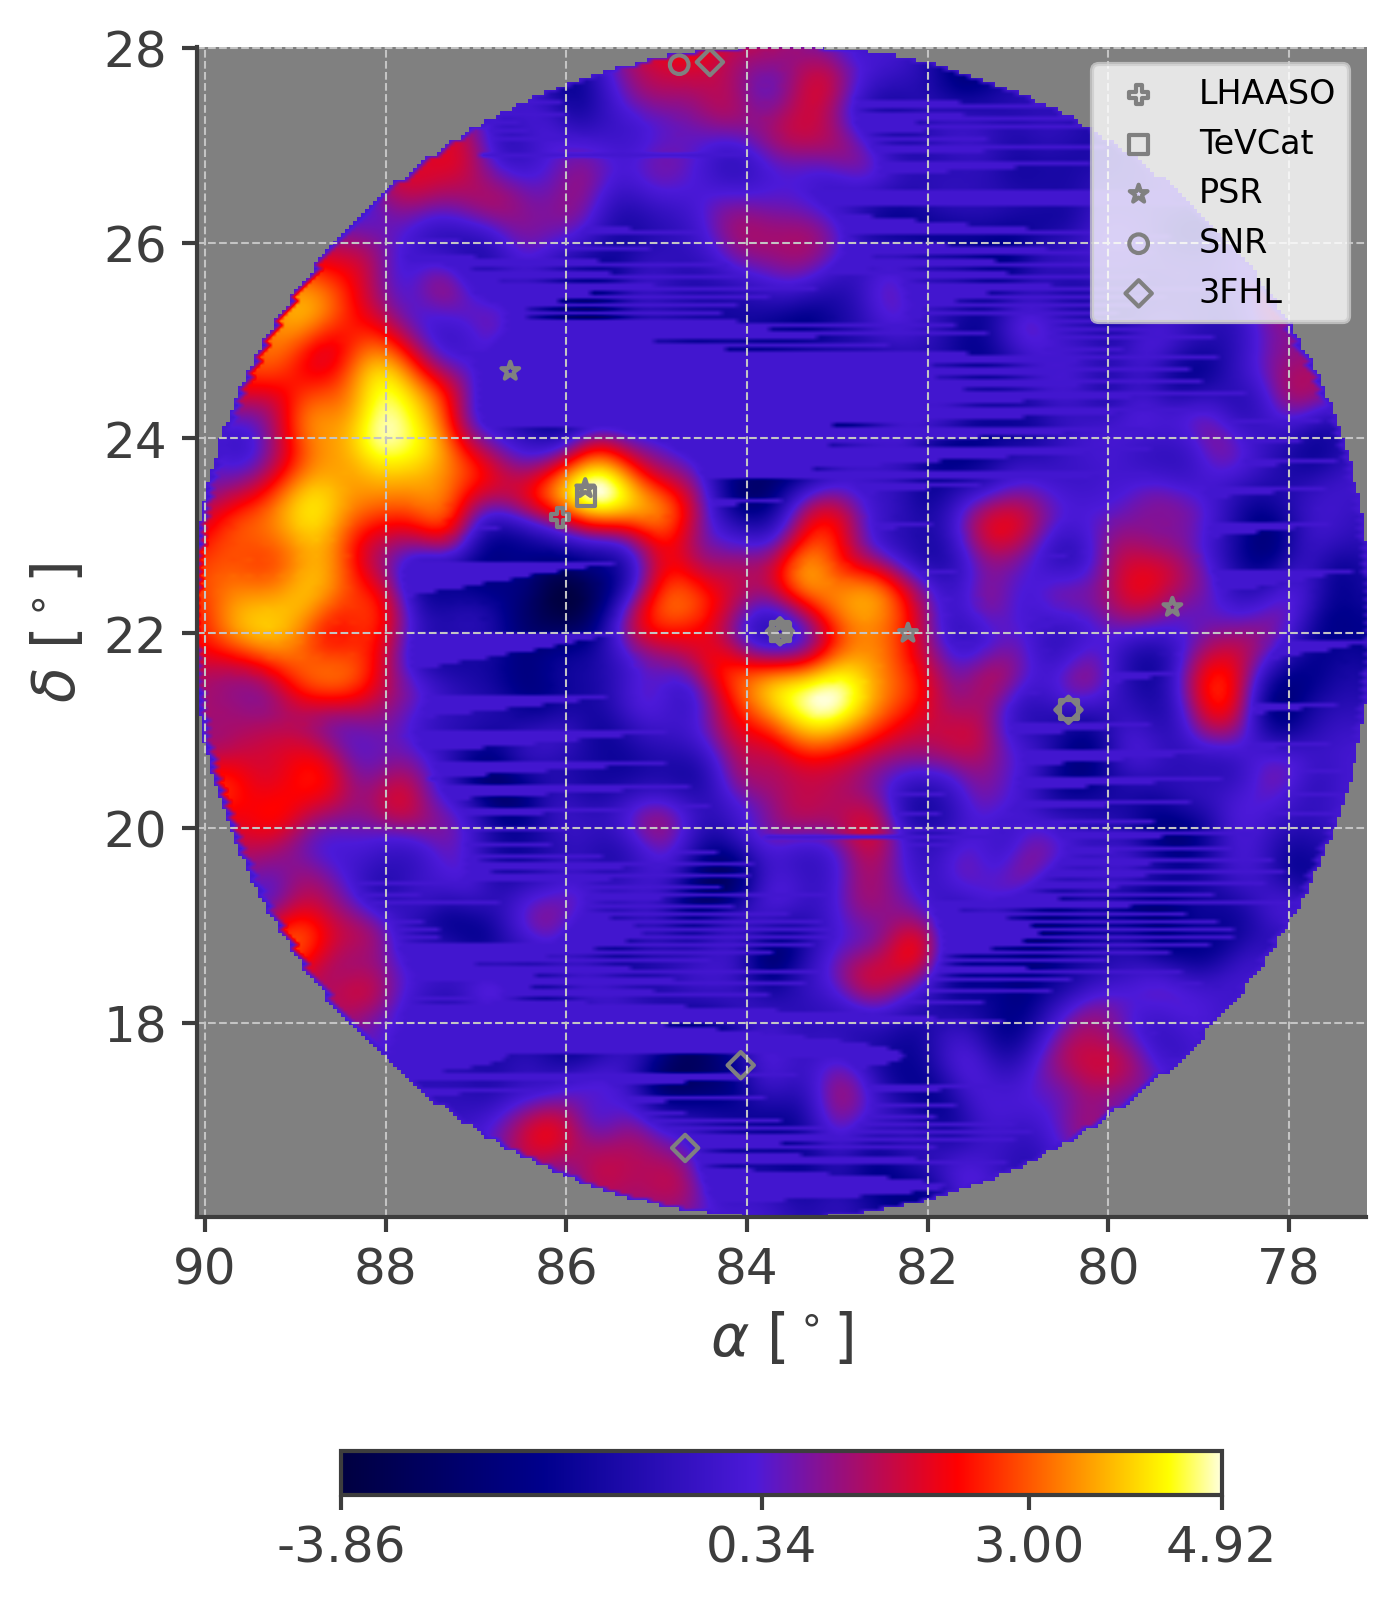

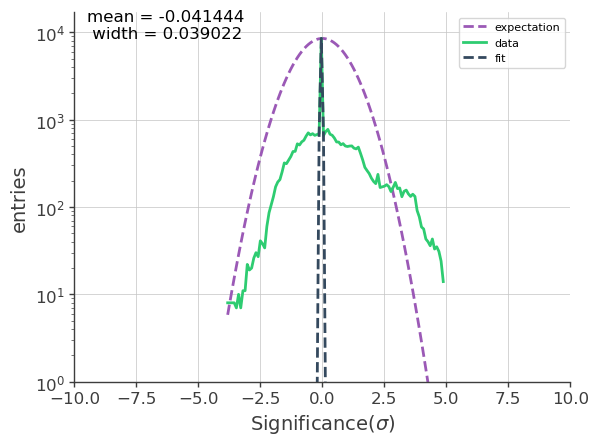

In [38]:
%matplotlib inline
resmap = my.getllhskymap("crab_res_res", region_name, ra1, dec1, data_radius, ifsave=True, ifdraw=1, tofits=1, detector="KM2A")
my.getsig1D(resmap, region_name, Modelname, region_name)

In [ ]:
#About 5 min
smoothsigma=[0.4123, 0.3111, 0.2476, 0.2064, 0.1633, 0.1379, 0.2896, 0.2594, 0.2152, 0.189, 0.1561, 0.14]#The first six bins are normal, and the following ones are merged bins, representing the total (merged), without the first bin, and without the first two bins, respectively.
maps = my.getmap(KM2A,roi,"Crab",
                 modelindex=[1,2], # modelindex: pt and ext number
               # pta=[0], exta=[0],
                   stack=[1.010229, 1.020917, 1.040597, 1.064803, 1.090451, 1.130015], #Combine bins with all bin based on signal-to-noise ratio.
                  #  stack=[0, 0, 1.002131,1.005977,1.002093,1.004078], #Combine bins with nhit >= 200 based on signal-to-noise ratio.
                  #  stack=[0, 1.002131,1.005977,1.002093,1.004078],
                   smoothsigma=smoothsigma
                   #, binc=["1","2","3","4","5"]
                   )
smapall = my.smoothmap(maps[-1], smooth_sigma=0.2896)

In [ ]:
%matplotlib inline
psfdata = my.Draw_lateral_distribution(region_name, Modelname, maps[0], 83.622, 22.002, 20, 0.1, True)

In [ ]:
%matplotlib inline
res=True # Do you want resmap? or org map.
saven = "Significance"
if res:
    saven+="_res"
sigmap = my.getsigmap(region_name, Modelname, [smapall],i=0,signif=17,res=res,name="Crab")
fig = my.drawmap(region_name, Modelname, sources, sigmap, ra1, dec1, rad=2*data_radius, contours=[1000],save=True,savename=saven)
#There is another source around crab, so you can try another model: 1pt+1gaus maybe?